In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd

%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os, pickle
import pickle

def _load_data_(files):
    X = np.empty([0, 3072])
    y = np.empty([0])
    for path in files:
        print(path)
        with open(path, "rb") as f:
            d = pickle.load(f, encoding='bytes')
            X = np.vstack([X, d[b"data"]]).astype("uint8")
            y = np.hstack([y, d[b"labels"]]).astype("uint8")
    return X, y

def load_data(data_path):
    training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
    test_files = [os.path.join(data_path, "test_batch")]
    labels_file = os.path.join(data_path, "batches.meta")

    X_train, y_train = _load_data_(training_files)
    X_test, y_test = _load_data_(test_files)

    X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
    X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255

    with open(labels_file, "rb") as f:
        labels = pickle.load(f, encoding="bytes")
    labels = [s.decode("utf-8")  for s in labels[b'label_names']]
    return X_train, X_test, y_train, y_test, labels

X_train, X_test, y_train, y_test, labels = load_data("/data/cifar-10-batches-py/")
print("X_train:", X_train.shape, 
      "\nX_test:", X_test.shape, 
      "\ny_train: ", y_train.shape, 
      "\ny_test:", y_test.shape, 
      "\nlabels: ", labels)

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch
X_train: (50000, 32, 32, 3) 
X_test: (10000, 32, 32, 3) 
y_train:  (50000,) 
y_test: (10000,) 
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
pd.Series(y_test).value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [4]:
eye = np.eye(len(labels))
Y_train = eye[y_train]
Y_test = eye[y_test]
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

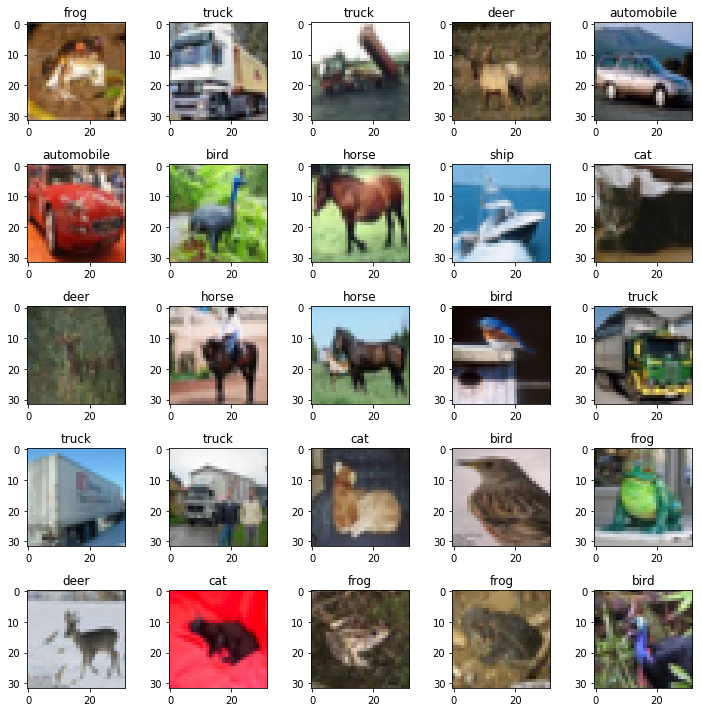

In [5]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_train[i])
    label = labels[y_train[i]]
    ax.set_title(label)
    
plt.tight_layout()

In [6]:
tf.set_random_seed(1)
np.random.seed(1)
num_classes = len(labels)

def build_model(input_shape, num_classes):
    with tf.device('/cpu:0'):
        from keras import layers
        model = keras.Sequential()
        model.add(layers.Conv2D(activation="relu", 
                                filters=32, 
                                kernel_size=(5, 5), 
                                input_shape = input_shape))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(activation="relu", 
                            filters=64, 
                            kernel_size=(5, 5)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(rate=0.8))
        model.add(layers.Dense(400, activation="relu"))
        model.add(layers.Dense(num_classes, activation="softmax"))
        model.compile(loss=keras.losses.categorical_crossentropy
                      , metrics=["accuracy"]
                      , optimizer="adam")
    return model

model = build_model(X_train.shape[1:], num_classes)
model.summary()

model.fit(x=X_train
          , y = Y_train
          , validation_data = (X_test, Y_test)
          , batch_size = 16
          , epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               640400    
__________